In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
%load_ext sql
%sql postgresql://localhost:5432/grav_29_1
%sql create extension if not exists postgis
%sql

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1


In [3]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

def spectrum(raster, gammas, dgamma = 1.0):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-dgamma/2, g+dgamma/2)
        rasters.append(_raster)
    return rasters

## Parameters

In [5]:
# Gaussian filter sigma, km
sigmaskm = np.linspace(25,1425,29)
sigmaskm

array([  25.,   75.,  125.,  175.,  225.,  275.,  325.,  375.,  425.,
        475.,  525.,  575.,  625.,  675.,  725.,  775.,  825.,  875.,
        925.,  975., 1025., 1075., 1125., 1175., 1225., 1275., 1325.,
       1375., 1425.])

## Raster from file

In [6]:
da = xr.open_dataarray('WGM2012_Bouguer_ponc_2min.grd').squeeze(drop=True)
da

<xarray.DataArray 'z' (y: 5401, x: 10801)>
[58336201 values with dtype=float32]
Coordinates:
  * x        (x) float32 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0 180.0
  * y        (y) float32 -90.0 -89.97 -89.93 -89.9 ... 89.9 89.93 89.97 90.0
Attributes:
    long_name:     z
    actual_range:  [-528.96435547 1005.01184082]

In [7]:
# reduce dataset size
da = da.coarsen({'y':10, 'x':10}, boundary='trim').mean()

## Raster to Database

In [8]:
%%time
da.to_dataframe(name='z').to_csv('data.csv', header=False)

CPU times: user 1.9 s, sys: 99.1 ms, total: 2 s
Wall time: 2.05 s


In [9]:
fname = !pwd
fname = fname[0] + '/data.csv'

In [10]:
%%time
%%sql

create extension if not exists postgis;
drop table if exists data;
create table data (lat float, lon float, z float, the_geom geography(Point, 4326));
COPY data (lat, lon, z) FROM :fname WITH DELIMITER ',';
UPDATE data SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX data_the_geom_idx ON data USING GIST (the_geom);
ANALYZE data;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
Done.
583200 rows affected.
583200 rows affected.
Done.
Done.
CPU times: user 15.2 ms, sys: 5.37 ms, total: 20.6 ms
Wall time: 9.97 s


[]

## Grid to Database

In [11]:
grid = da[::150,::150]
print (grid.shape[0]*grid.shape[1])
grid

32


<xarray.DataArray (y: 4, x: 8)>
array([[ 10.485208 ,  10.502791 ,  10.767742 ,   7.4754553,   6.9853845,
          7.3480015,  11.271319 ,  11.102231 ],
       [440.31946  , 524.69763  , 439.08557  , 487.73233  , 526.54584  ,
        483.31754  , 498.99692  , 245.09454  ],
       [611.9866   , 511.83176  , 247.19864  , 534.7815   ,  53.175102 ,
        398.77264  , 264.73767  , 441.2465   ],
       [245.8812   ,  34.478    ,  58.339355 , 275.11057  ,  56.82889  ,
         82.52239  ,  51.2667   , 213.66219  ]], dtype=float32)
Coordinates:
  * x        (x) float32 -179.9 -129.9 -79.85 -29.85 20.15 70.15 120.2 170.1
  * y        (y) float32 -89.85 -39.85 10.15 60.15

In [12]:
grid.to_dataframe(name='z0').to_csv('grid.csv', header=False)

In [13]:
fname = !pwd
fname = fname[0] + '/grid.csv'

In [14]:
%%time
%%sql

drop table if exists grid;
create table grid (lat float, lon float, z0 float, the_geom geography(Point, 4326));
COPY grid (lat, lon, z0) FROM :fname WITH DELIMITER ',';
UPDATE grid SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX grid_the_geom_idx ON grid USING GIST (the_geom);
ANALYZE grid;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
32 rows affected.
32 rows affected.
Done.
Done.
CPU times: user 11 ms, sys: 4.51 ms, total: 15.5 ms
Wall time: 81.8 ms


[]

## Gaussian Filtering in Database

In [15]:
%%sql

DROP FUNCTION IF EXISTS gaussian_transform(sigma float, geom geography);
CREATE OR REPLACE FUNCTION gaussian_transform(sigma float, geom geography)
    RETURNS TABLE (z float, count bigint)
    AS '
with weights as (
    select
        z,
        exp(-(pow(ST_Distance($2,the_geom,false),2))/(2*pow($1,2))) as weight
    from data
    where ST_Buffer($2,4.*$1) && the_geom and ST_DWithin($2, the_geom, 4.*$1)
)
select
    sum(z*weight)/sum(weight) as z,
    count(1) as count
from weights
'
LANGUAGE SQL STABLE;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.


[]

In [16]:
%%time

%sql drop table if exists gaussian_transform;
%sql create table gaussian_transform (sigmakm int, lat float, lon float, z0 float, z float, count bigint);

for sigmakm in sigmaskm:
    print ("sigmakm", sigmakm)
    %sql insert into gaussian_transform \
         select :sigmakm, lat, lon, z0, t.* from grid, gaussian_transform(:sigmakm*1000, the_geom) as t;

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1
Done.
sigmakm 25.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 75.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 125.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 175.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 225.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 275.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 325.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 375.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 425.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 475.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 525.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 575.0
 * postgresql://localhost:5432/grav_29_1
32 rows affected.
sigmakm 625.0
 * postgresql://lo

## Show Gaussian Transform map

In [17]:
%sql gaussian << select * from gaussian_transform

 * postgresql://localhost:5432/grav_29_1
928 rows affected.
Returning data to local variable gaussian


In [18]:
gaussian = gaussian.DataFrame()

In [19]:
gaussian = gaussian.set_index(['sigmakm','lat','lon']).to_xarray()
gaussian

<xarray.Dataset>
Dimensions:  (lat: 4, lon: 8, sigmakm: 29)
Coordinates:
  * sigmakm  (sigmakm) int64 25 75 125 175 225 275 ... 1225 1275 1325 1375 1425
  * lat      (lat) float64 -89.85 -39.85 10.15 60.15
  * lon      (lon) float64 -179.9 -129.9 -79.85 -29.85 20.15 70.15 120.2 170.1
Data variables:
    z0       (sigmakm, lat, lon) float64 10.49 10.5 10.77 ... 82.52 51.27 213.7
    z        (sigmakm, lat, lon) float64 8.66 8.825 9.565 ... 97.37 113.5 241.7
    count    (sigmakm, lat, lon) int64 2863 2863 2863 ... 151522 151661 151402

In [20]:
%%time
# discrete power spectrum
power_spectrum = gaussian.std(['lat','lon'])['z'].rename('spectrum')

CPU times: user 2.46 ms, sys: 1.78 ms, total: 4.24 ms
Wall time: 3.7 ms


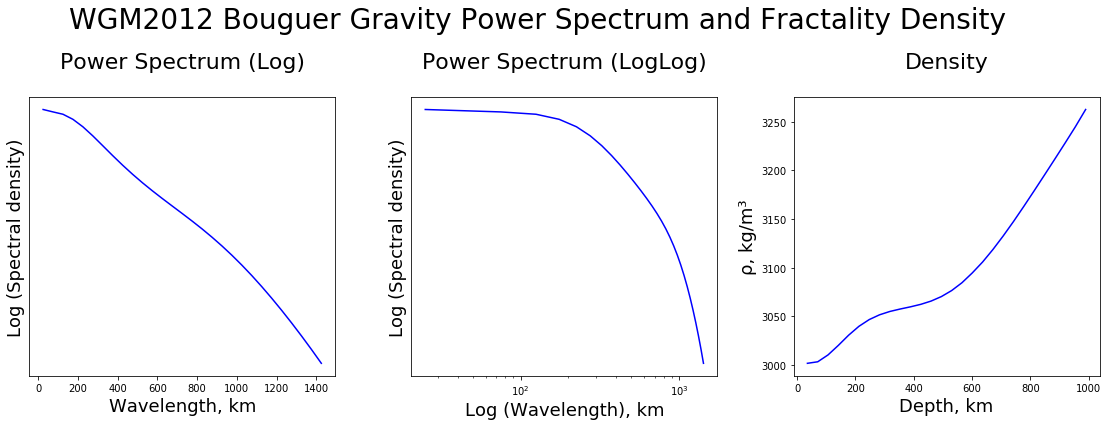

In [22]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1, 3, 1)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_yscale('log')
ax.set_title(f'Power Spectrum (Log)\n', fontsize=22)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Wavelength, km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)

ax = fig.add_subplot(1, 3, 2)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Power Spectrum (LogLog)\n', fontsize=22)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Log (Wavelength), km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)

ax = fig.add_subplot(1, 3, 3)
# calculate fractality index
slope = np.diff(np.log10(power_spectrum))/np.diff(np.log10(power_spectrum.sigmakm))
depths = (power_spectrum.sigmakm.values[1:]+power_spectrum.sigmakm.values[:-1])/2/np.sqrt(2)
fractal = (3 - (slope/2))
ax.plot(depths, 1000*fractal, c='blue')
ax.set_title(f'Density\n', fontsize=22)
ax.set_ylabel('ρ, kg/m³',fontsize=18)
ax.set_xlabel('Depth, km', fontsize=18)

plt.suptitle('WGM2012 Bouguer Gravity Power Spectrum and Fractality Density', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('Spectral Components Analysis [WGM2012 Bouguer].jpg', dpi=150, quality=95)
plt.show()